# Task 2: Data Profiling, Cleaning & EDA
**Objective:** Profile, clean, and explore the solar dataset for Benin so it’s ready for comparison and region-ranking tasks.

This notebook includes:
- Summary statistics and missing-value report
- Outlier detection and cleaning
- Time series analysis
- Correlation and scatter plots
- Wind and temperature analysis
- Bubble charts

## Importing the dependencies

In [93]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Setting the plotting style and Loading the Data

In [94]:
# Set both plotting and display settings
sns.set_palette("husl")
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\benin-malanville.csv")


In [95]:
# Show basic info
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (525600, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  T

In [96]:
#  Display column names
print("\nColumn names:")
print(df.columns.tolist())


Column names:
['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


In [97]:
#  Display the first 5 rows
print("\nFirst 5 rows:")
display(df.head())


First 5 rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [98]:
# Display the last 10 rows
print("\nLast 10 rows:")
display(df.tail(10))


Last 10 rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
525590,2022-08-08 23:51,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.3,0.6,1.3,0.6,95.9,6.2,996,0,0.0,23.4,22.8,NaN
525591,2022-08-08 23:52,-5.5,0.0,-5.8,0.0,0.0,23.1,98.3,0.4,1.1,0.5,94.0,2.5,996,0,0.0,23.4,22.8,NaN
525592,2022-08-08 23:53,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.4,0.3,1.1,0.5,103.5,1.9,996,0,0.0,23.5,22.9,NaN
525593,2022-08-08 23:54,-5.5,-0.1,-5.9,0.0,0.0,23.1,98.4,0.1,1.1,0.3,94.3,1.5,996,0,0.0,23.5,22.9,NaN
525594,2022-08-08 23:55,-5.5,-0.1,-5.9,0.0,0.0,23.1,98.3,0.1,1.1,0.3,112.2,0.7,996,0,0.0,23.5,22.9,NaN
525595,2022-08-08 23:56,-5.5,-0.1,-5.9,0.0,0.0,23.1,98.3,0.3,1.1,0.5,119.3,4.1,996,0,0.0,23.5,22.9,NaN
525596,2022-08-08 23:57,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.3,0.2,0.7,0.4,115.2,2.3,996,0,0.0,23.5,22.9,NaN
525597,2022-08-08 23:58,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.4,0.6,1.1,0.5,129.8,3.4,996,0,0.0,23.5,22.9,NaN
525598,2022-08-08 23:59,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.3,0.9,1.3,0.5,124.4,4.3,996,0,0.0,23.5,22.9,NaN
525599,2022-08-09 00:00,-5.5,-0.1,-5.7,0.0,0.0,23.1,98.3,1.2,1.6,0.3,124.1,5.9,996,0,0.0,23.5,22.9,NaN


In [99]:
# Display 10 random sample rows
print("\nRandom sample of 10 rows:")
display(df.sample(10, random_state=42))


Random sample of 10 rows:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
97300,2021-10-15 13:41,931.0,864.0,143.8,949.0,948.0,36.8,39.4,2.9,3.4,0.4,18.6,6.7,993,0,0.0,65.2,56.6,NaN
123024,2021-11-02 10:25,618.2,212.1,449.6,641.4,641.1,29.3,64.5,0.6,1.3,0.6,159.7,11.3,998,0,0.0,59.0,51.3,NaN
135493,2021-11-11 02:14,-1.8,-0.3,-2.9,0.0,0.0,25.4,78.4,1.9,2.4,0.4,241.4,10.9,993,0,0.0,24.7,24.1,NaN
514148,2022-08-01 01:09,-0.8,-0.1,-0.8,0.0,0.0,22.6,95.5,0.0,0.0,0.0,0.0,0.0,995,0,0.0,22.6,21.9,NaN
468828,2022-06-30 13:49,820.0,387.9,438.0,725.2,715.7,31.9,60.6,2.5,3.4,0.5,185.4,26.5,995,0,0.0,59.7,50.5,NaN
251778,2022-01-30 20:19,-5.4,-0.7,-7.7,0.0,0.0,24.5,19.7,2.4,2.9,0.4,40.9,6.9,997,0,0.0,20.9,21.3,NaN
32100,2021-08-31 07:01,22.1,-0.2,22.1,23.3,23.2,23.8,98.7,1.8,2.9,0.6,51.1,10.6,998,0,0.0,24.4,24.0,NaN
263477,2022-02-07 23:18,-2.0,-0.8,-2.0,0.0,0.0,20.3,38.0,0.0,0.0,0.0,0.0,0.0,996,0,0.0,18.4,17.2,NaN
152664,2021-11-23 00:25,-1.6,-0.6,-1.7,0.0,0.0,20.8,69.5,0.1,0.7,0.4,219.8,0.0,995,0,0.0,18.7,17.6,NaN
187318,2021-12-17 01:59,-5.2,-0.9,-6.8,0.0,0.0,18.1,42.5,0.1,0.7,0.3,69.1,0.0,997,0,0.0,15.7,14.6,NaN


In [100]:
# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Percentage of missing values per column
print("\nPercentage of missing values:")
print((df.isna().mean() * 100).round(2))

# Show only columns with any missing values
missing = df.isna().sum()
missing = missing[missing > 0]
print("\nColumns with missing values:")
print(missing)





Missing values per column:
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
                  ...  
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
Length: 19, dtype: int64

Percentage of missing values:
Timestamp          0.0
GHI                0.0
DNI                0.0
DHI                0.0
ModA               0.0
                 ...  
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
Comments         100.0
Length: 19, dtype: float64

Columns with missing values:
Comments    525600
dtype: int64


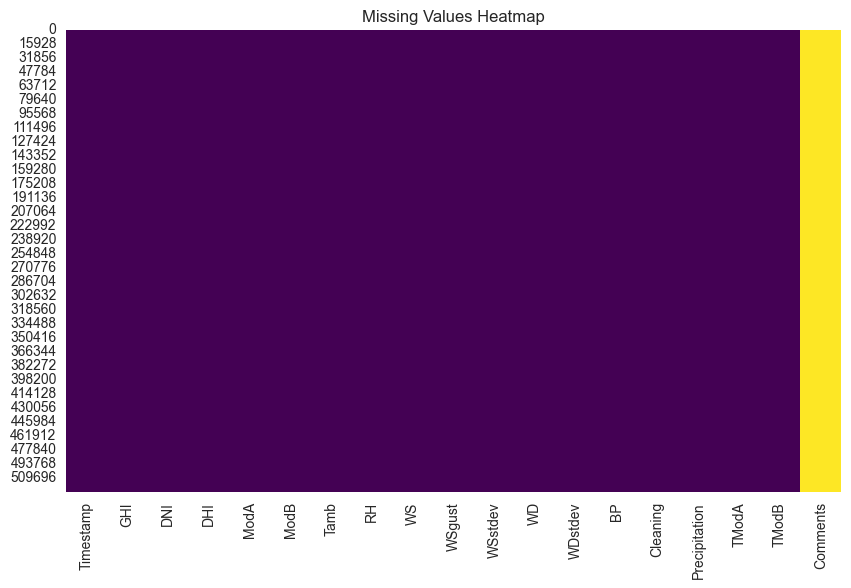

In [101]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [102]:
# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
display(df.describe())


Summary statistics for numeric columns:


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
std,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN
min,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN


In [103]:
# Show description of all categorical (non-numeric) columns
cat_description = df.describe(include=['object', 'category'])
display(cat_description)

,Timestamp
count,525600
unique,525600
top,2021-08-09 00:01
freq,1


In [104]:
# Show description of all numerical and categorical columns
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
numeric_summary = df.describe()
display(numeric_summary.T)  # Transposed for readability
full_summary = df.describe(include='all')
display(full_summary.T)

df.describe(include='all')

,count,mean,min,25%,50%,75%,max,std
Timestamp,525600,2022-02-07 12:00:30.000000512,2021-08-09 00:01:00,2021-11-08 06:00:45,2022-02-07 12:00:30,2022-05-09 18:00:15,2022-08-09 00:00:00,NaN
GHI,525600.0,240.559452,-12.9,-2.0,1.8,483.4,1413.0,331.131327
DNI,525600.0,167.187516,-7.8,-0.5,-0.1,314.2,952.3,261.710501
DHI,525600.0,115.358961,-12.6,-2.1,1.6,216.3,759.2,158.691074
ModA,525600.0,236.589496,0.0,0.0,4.5,463.7,1342.3,326.894859
...,...,...,...,...,...,...,...,...
Cleaning,525600.0,0.000923,0.0,0.0,0.0,0.0,1.0,0.030363
Precipitation,525600.0,0.001905,0.0,0.0,0.0,0.0,2.5,0.037115
TModA,525600.0,35.246026,9.0,24.2,30.0,46.9,81.0,14.807258
TModB,525600.0,32.471736,8.1,23.6,28.9,41.5,72.5,12.348743


,count,mean,min,25%,50%,75%,max,std
Timestamp,525600,2022-02-07 12:00:30.000000512,2021-08-09 00:01:00,2021-11-08 06:00:45,2022-02-07 12:00:30,2022-05-09 18:00:15,2022-08-09 00:00:00,NaN
GHI,525600.0,240.559452,-12.9,-2.0,1.8,483.4,1413.0,331.131327
DNI,525600.0,167.187516,-7.8,-0.5,-0.1,314.2,952.3,261.710501
DHI,525600.0,115.358961,-12.6,-2.1,1.6,216.3,759.2,158.691074
ModA,525600.0,236.589496,0.0,0.0,4.5,463.7,1342.3,326.894859
...,...,...,...,...,...,...,...,...
Cleaning,525600.0,0.000923,0.0,0.0,0.0,0.0,1.0,0.030363
Precipitation,525600.0,0.001905,0.0,0.0,0.0,0.0,2.5,0.037115
TModA,525600.0,35.246026,9.0,24.2,30.0,46.9,81.0,14.807258
TModB,525600.0,32.471736,8.1,23.6,28.9,41.5,72.5,12.348743


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-02-07 12:00:30.000000512,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
min,2021-08-09 00:01:00,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,2021-11-08 06:00:45,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,2022-02-07 12:00:30,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN
std,NaN,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN


In [105]:
# Display all rows that are exact duplicates
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
display(duplicate_rows)

Number of duplicate rows: 0


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments


## Univariate Annalysis

                  count        mean         std   min   25%   50%    75%  \
GHI            525600.0  240.559452  331.131327 -12.9  -2.0   1.8  483.4   
DNI            525600.0  167.187516  261.710501  -7.8  -0.5  -0.1  314.2   
DHI            525600.0  115.358961  158.691074 -12.6  -2.1   1.6  216.3   
ModA           525600.0  236.589496  326.894859   0.0   0.0   4.5  463.7   
ModB           525600.0  228.883576  316.536515   0.0   0.0   4.3  447.9   
...                 ...         ...         ...   ...   ...   ...    ...   
Cleaning       525600.0    0.000923    0.030363   0.0   0.0   0.0    0.0   
Precipitation  525600.0    0.001905    0.037115   0.0   0.0   0.0    0.0   
TModA          525600.0   35.246026   14.807258   9.0  24.2  30.0   46.9   
TModB          525600.0   32.471736   12.348743   8.1  23.6  28.9   41.5   
Comments            0.0         NaN         NaN   NaN   NaN   NaN    NaN   

                  max  
GHI            1413.0  
DNI             952.3  
DHI            

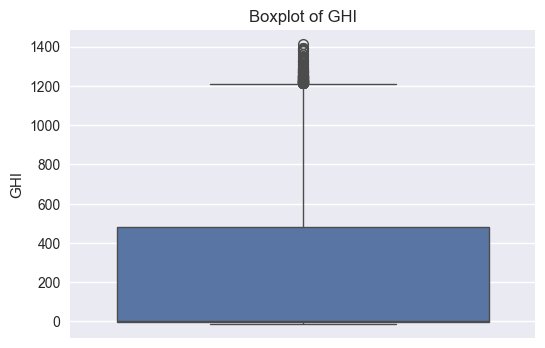

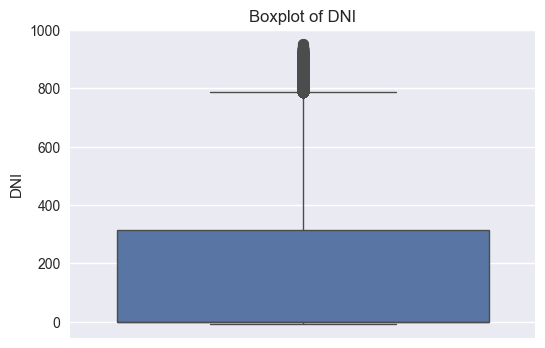

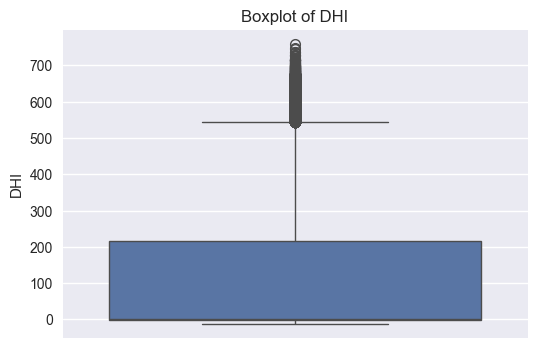

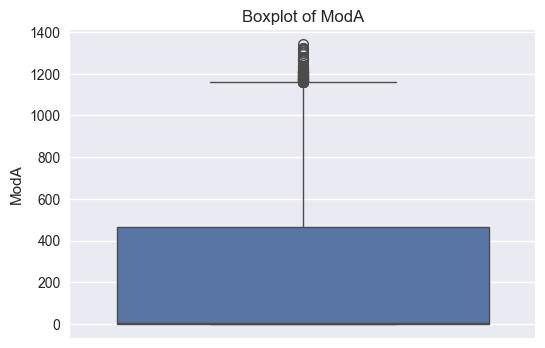

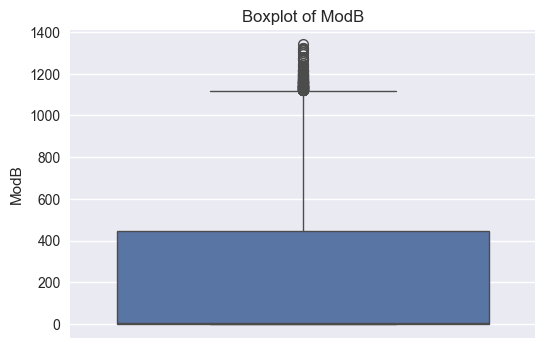

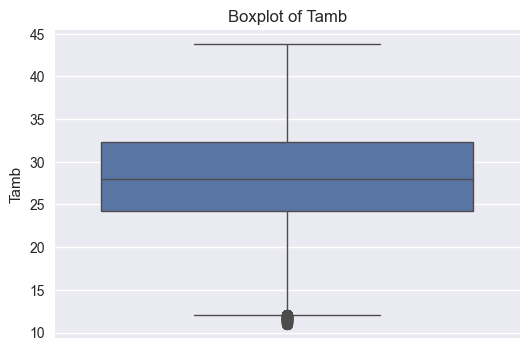

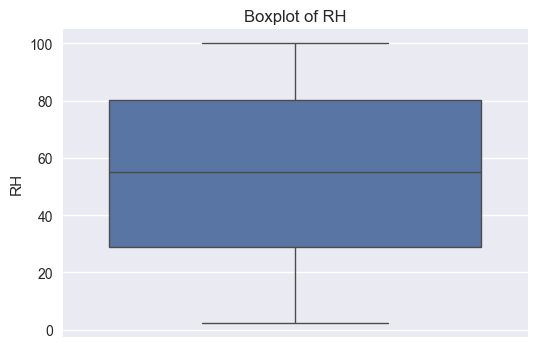

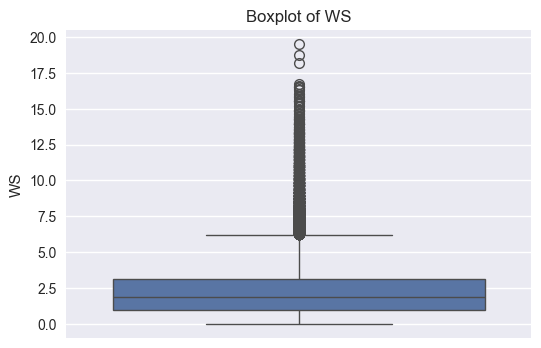

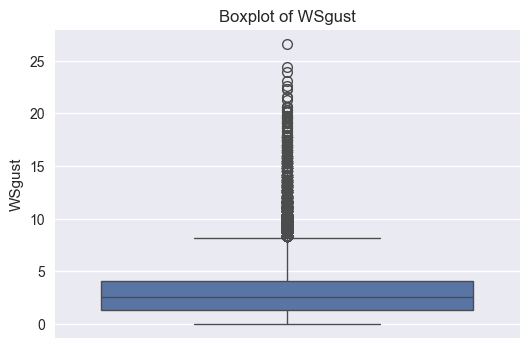

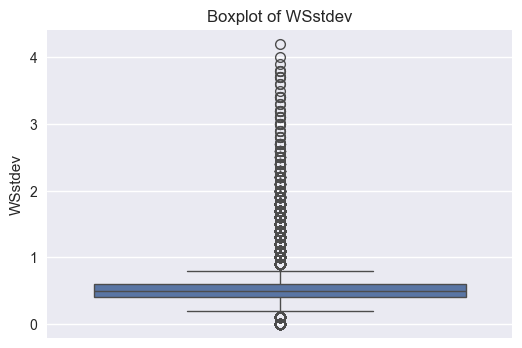

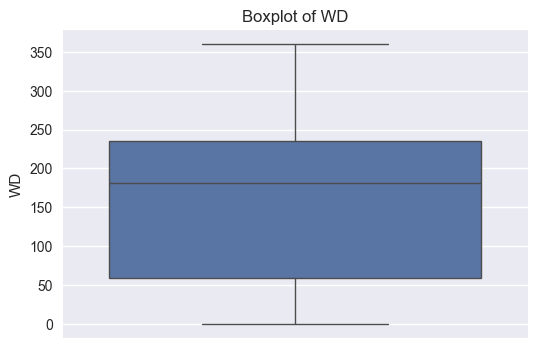

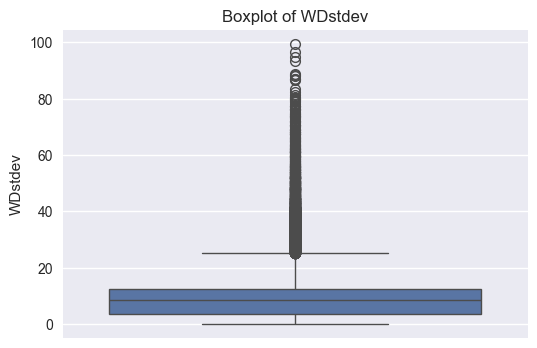

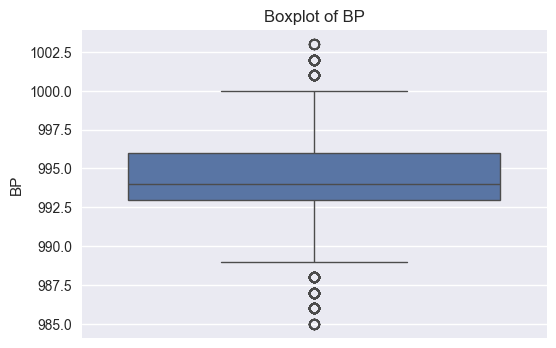

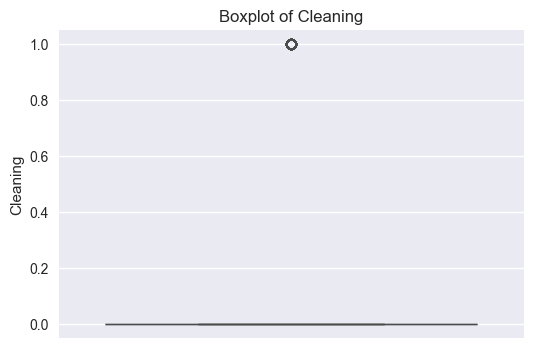

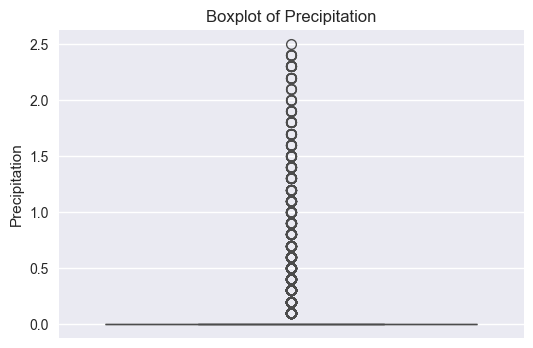

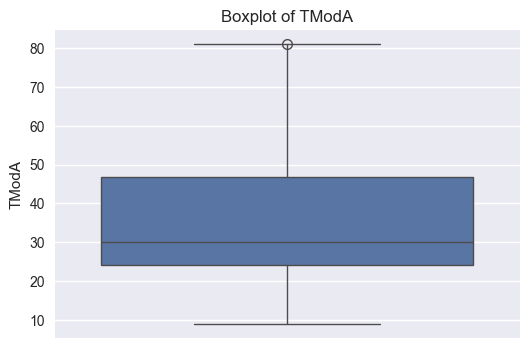

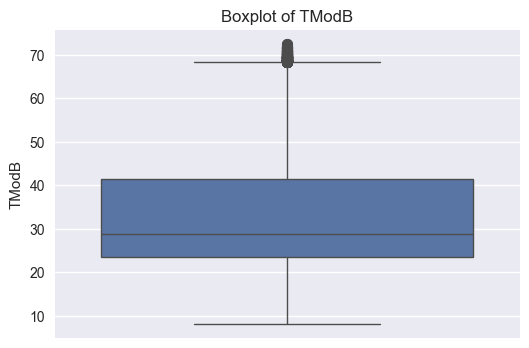

ValueError: List of boxplot statistics and `positions` values must have same the length

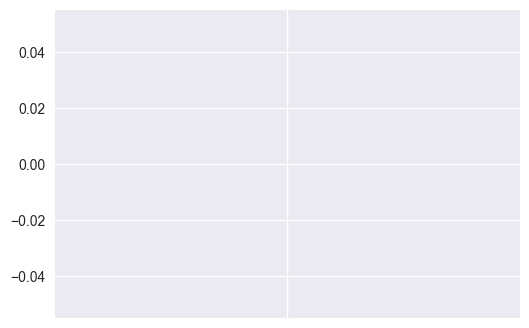

In [ ]:
# Univariate Analysis Numeric columns only
numeric_cols = df.select_dtypes(include=np.number).columns
print(df[numeric_cols].describe().T)

# using box plot
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
# using histograms    
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()